## 0. Imports, and some constants definitions

In [2]:
import json
import logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from itertools import product
import re

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('text', usetex = True)

# Mapping for beautiful algorithms and distances names
ALGS = {
    "pct_": "PrimConsTree V2",
    "pct_old_PrimTrue": "PrimConsTree V1",
    "maj_": "Ext. majority rule",
    "maj_plus_avgTrue": "Majority rule + (avg)",
    "maj_plus_cst1": "Majority rule + (cst 1)",
    "fdct_avgTrue": "Frequency difference (avg)",
    "fdct_cst1": "Frequency difference (cst 1)",
}
DISTS = {
    "rf_": "Robinson and Foulds distance",
    "tdist_": "Triplet distance",
    "qdist_": "Quartet distance",
    "bsd_": "Branch score distance",
    "kcdist_lamb0.0": r"Kendall-Colijn distance ($\lambda = 0.0$)",
    "kcdist_lamb0.5": r"Kendall-Colijn distance ($\lambda = 0.5$)",
    "kcdist_lamb1.0": r"Kendall-Colijn distance ($\lambda = 1.0$)",
    "kcdist": r"Kendall-Colijn distance",
    "duration": "Duration (seconds)",
}
PARAMS = {
    "k": r"Number of trees ($\mathit{k}$)",
    "n": r"Number of leaves ($\mathit{n}$)",
    "c": r"Coalescence rate ($\mathit{c}$)",
    "lambda": r"$\lambda$",
}

### 0.1. Some helper functions mostly for plots

In [3]:
def get_lambda(name: str) -> float | None:
    """ Given a metric id return the corresponding lambda
    parameter if it is present, None otherwise.
    Lambda is a parameter for the kendall colijn metric
    """
    pattern = r'lamb([-+]?\d*\.\d+|\d+)'

    match = re.search(pattern, name)
    if match:
        return float(match.group(1))
    else:
        return None
        
def plot_metric(data, metric, xs, algs, **args):
    """ Plots results of algorithms in <algs> for a given metric <metric>, 
    with respect to each parameter in <xs> (on plot per parameter)
    Args:
        data: the dataframa containing the run data
        metric: the id of the metric to plot (ex. rf_, kcdist_lamb0.0, bsd_, )
        xs: the parameters to plot for (ex. ["k", "n"] for number of trees and number of leaves)
        algs: the algorithms to plot for (ex. [ALGS["pct_"], ALGS["maj_"], ])
        args: additional parameter passed to the ploting function (ex. errorbar=None)
    """
    fig, axes = plt.subplots(nrows=1, ncols=len(xs), figsize=(20/3*len(xs), 5))
    algs_data = data[data["algorithm"].isin(algs)]
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    for ax, x in zip(axes, xs):
        sns.lineplot(x=x, y=metric, hue="algorithm", data=algs_data, ax=ax, markers=True, style="algorithm", dashes=False, **args)
        ax.set_xlabel(PARAMS[x])
        ax.set_ylabel(DISTS[metric])
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=labels)  
    return fig, axes

def figure(data, metrics, xs, algs, **args):
    """ Similar to plot_metric(), but take multiple metrics and
    draw a two dimentional plot (metric x parameter)
    """
    fig, axes = plt.subplots(nrows=len(xs), ncols=len(metrics), figsize=(6*len(metrics), 5*len(xs)))
    algs_data = data[data["algorithm"].isin(algs)]
    for i, x in enumerate(xs):
        for j, metric in enumerate(metrics):
            ax = axes[i][j]
            sns.lineplot(x=x, y=metric, hue="algorithm", data=algs_data, ax=ax, markers=True, style="algorithm", dashes=False, errorbar=None, **args)
            ax.set_xlabel(PARAMS[x])
            ax.set_ylabel(DISTS[metric])
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles, labels=labels)  
    return fig, axes

# Performance analysis of PrimConsTree

## Simulation design

Random trees are generated with the Hybrid Sim tool, using evry combinations of K, N, C.

Trees can be generated through the generate_input.py script and consensus are evaluated through the eval_consensus.py script. For both parameter can be modified from a dedicated section in the script directly.
Tree generation will require the [hybridsim tool](https://github.com/MichaelWoodhams/HybridSim) .jar archive which should already be included in srs/tools/. Java is required to be in the PATH to execute hybrid sim.
Evaluation script also require to have the [FACT](https://github.com/Mesh89/FACT) and [FACT2](https://github.com/Mesh89/FACT2) compiled programs, they are also already included but might not work. You can use the src/tools/setup_fact.sh script which require git, wget, tar, and g++, or you can build them yourself.

For each combination of K, N and C, we generated multiple batchs of input trees. We then computed the **PrimConsTree consensus tree**, the **previous PrimConsTree**, the **extended majority rule**, the **frequency difference** and the **majority rule +** for each batch. Additionally, we collected the following metrics on each batch:
- Average RF distance between the input trees and the consensus
- Average BSD distance between the input trees and the consensus
- Average Kendal-Colijn distance for several lambda
- Execution time to build the consensus tree



## Modifying the scripts

In case new algorithms or new metric are added, update the label mapping section 0. (respectively ALGS and DISTS) to include its name.

In case you want to change which algorithm is ploted, you can modify DEFAULT_ALGS in section 1. to change it globally. If you wish to change it for one plot only, refere to \<algs\> parameter of the plot_metric() function. 

If you wish to save a figure uncomment the plt.savefig() command and comment the plt.show() command. Note this override existing file without question if the path is not updated.

## Note on Latex

This notebook might require latex package installed. Latex is used only for labels on plots, in case this cause trouble you might want to modify the first cell of this notebook (section 0) so that matplotlib does not require latex and labels does not include latex commands. No further modification should be required

## 1. Fetch run data and organize them in a dataframe

In [4]:
# file outputed from eval_consensus.py
RESULTS_FILE = "../outputs/eval/All.json"
# default algs you want to plot
DEFAULT_ALGS = [
    "pct_",
    "pct_old_PrimTrue",
    "maj_",
    "fdct_cst1",
    "fdct_avgTrue",
    "maj_plus_cst1",
    "maj_plus_avgTrue"
]

with open(RESULTS_FILE, "r") as f:
    data = json.load(f)

run_algs = {a: ALGS[a] for a in ALGS if a in data[0]}
DEFAULT_ALGS = [ALGS[a] for a in DEFAULT_ALGS if a in data[0]]

formated = []
for d, a in product(data, run_algs.keys()):
    entry = {"algorithm": ALGS[a], "n": d["n"], "k": d["k"], "c": d["c"]}
    for metric in DISTS:
        if metric in d[a]:
            entry[metric] = d[a][metric]
    formated.append(entry)

df = pd.DataFrame(formated)
run_dists = [m for m in DISTS if m in df.columns]

## 2. Average RF for varying k, n, c

Robinson and Foulds distance is computed using the ete3 built in method. Given a batch of input trees, the RF distance is calculated beteween each input tree and the consensus tree and it is normalized between 0 and 1. Then the normalized RF distances are averaged in one value.

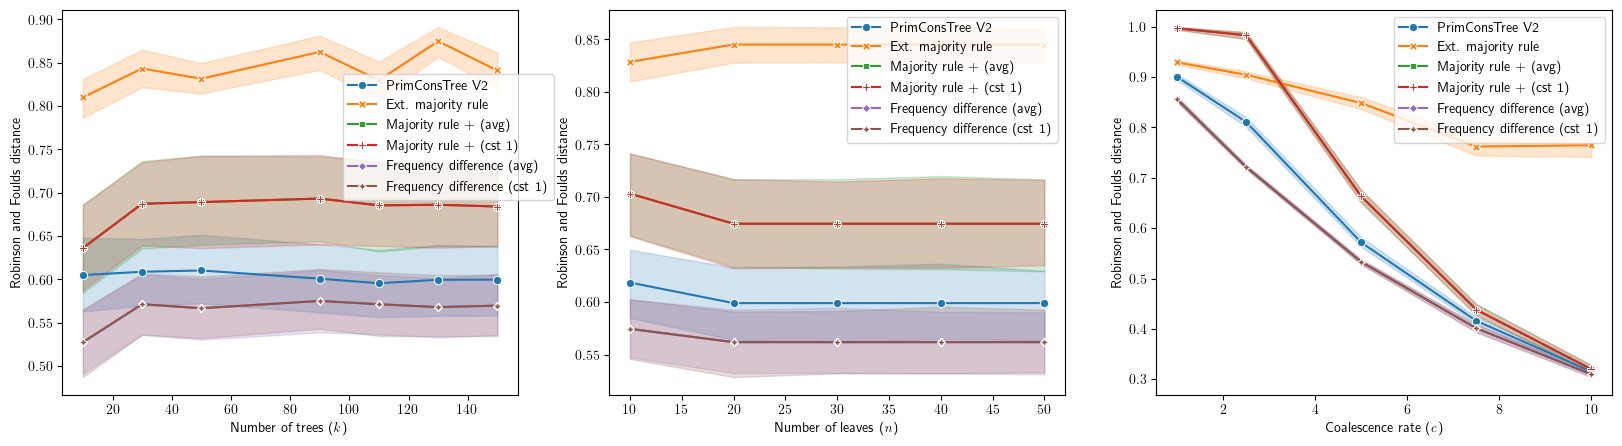

In [5]:
if "rf_" in run_dists:
    _, axes = plot_metric(df, "rf_", ["k", "n", "c"], DEFAULT_ALGS)
    axes[0].legend(loc='upper left', bbox_to_anchor=(0.6, 0.85))
    plt.show()
    #plt.savefig('../img/rf.pdf', dpi=300)

## 3 Average Triplet and Quartet dist

Measured with the [tqdist](https://www.birc.au.dk/~cstorm/software/tqdist/) tool. The average triplet distance between the consensus tree and every input tree is measured.
Triplet might be more relevant since the trees are rooted.

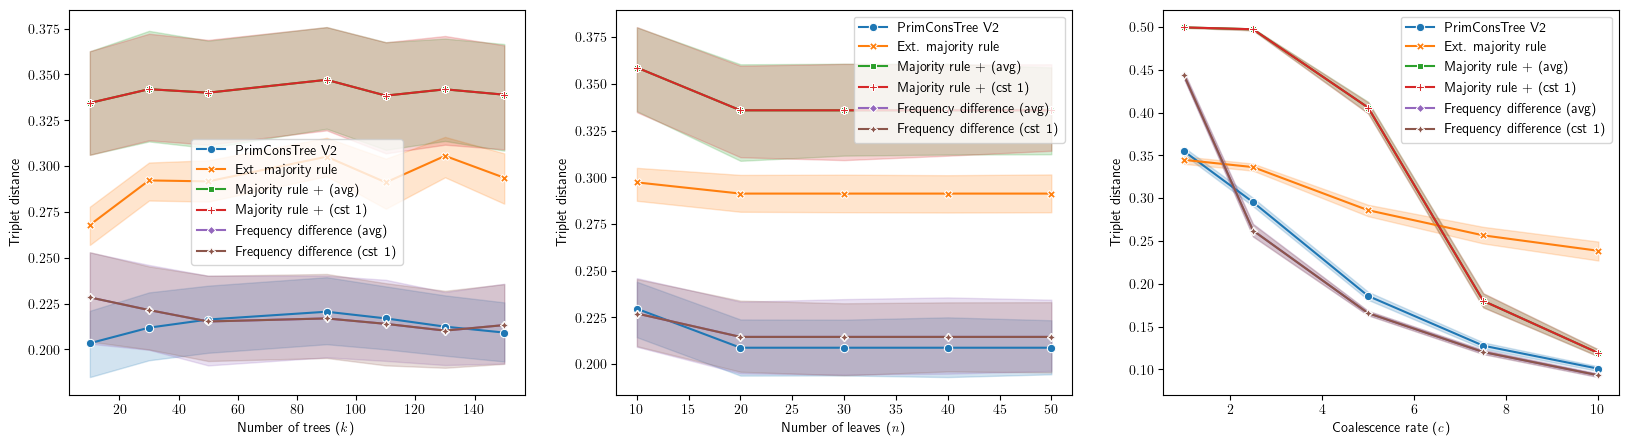

In [6]:
if "tdist_" in run_dists:
    plot_metric(df, "tdist_", ["k", "n", "c"], DEFAULT_ALGS)
    plt.show()
    #plt.savefig('../img/triplet.pdf', dpi=300)

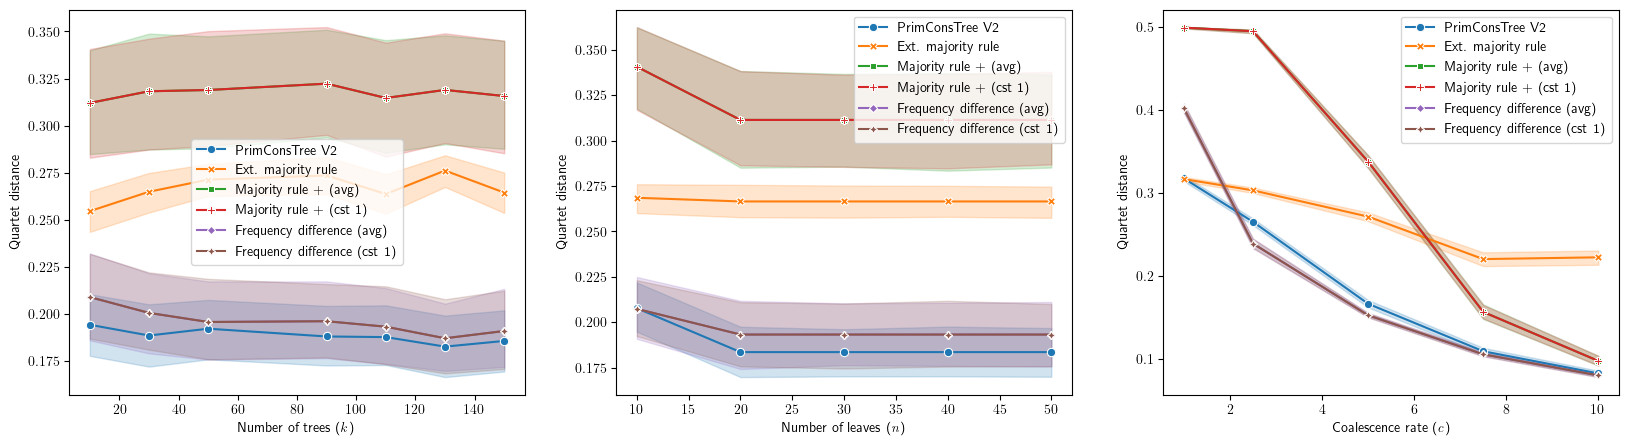

In [7]:
if "qdist_" in run_dists:
    plot_metric(df, "qdist_", ["k", "n", "c"], DEFAULT_ALGS)
    plt.show()
    #plt.savefig('../img/quartet.pdf', dpi=300)

## 4. Average BSD for varying k, n

Given 2 trees, the normalized BSD <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) is calculated the following way:

$$ BSD(T, T') = \sqrt{\sum_{i} (\frac{b_i}{size(T)} - \frac{b_i'}{size(T')})^2} $$

Where $B = \{b_1, b_2, ..., b_n\}$ is the set of **branch lengths** corresponding to each bipartition in the tree T and $B' = \{b_1', b_2', ..., b_n'\}$ is the set of **branch lengths** corresponding to the same bipartitions in the tree T'. When a bipartition is present in one tree but not in the other, the length of the missing bipartition is considered to be 0. Size(T) denote the sum of all bipartitions length in the tree T, dividing by this value provide a relative distance between the tree, instead of an absolute distance biased by the size of the trees.

<a name="cite_note-1"></a>[[1]](#cite_ref-1) : M K Kuhner, J Felsenstein, A simulation comparison of phylogeny algorithms under equal and unequal evolutionary rates. Molecular Biology and Evolution, Volume 11, Issue 3, May 1994, Pages 459–468,

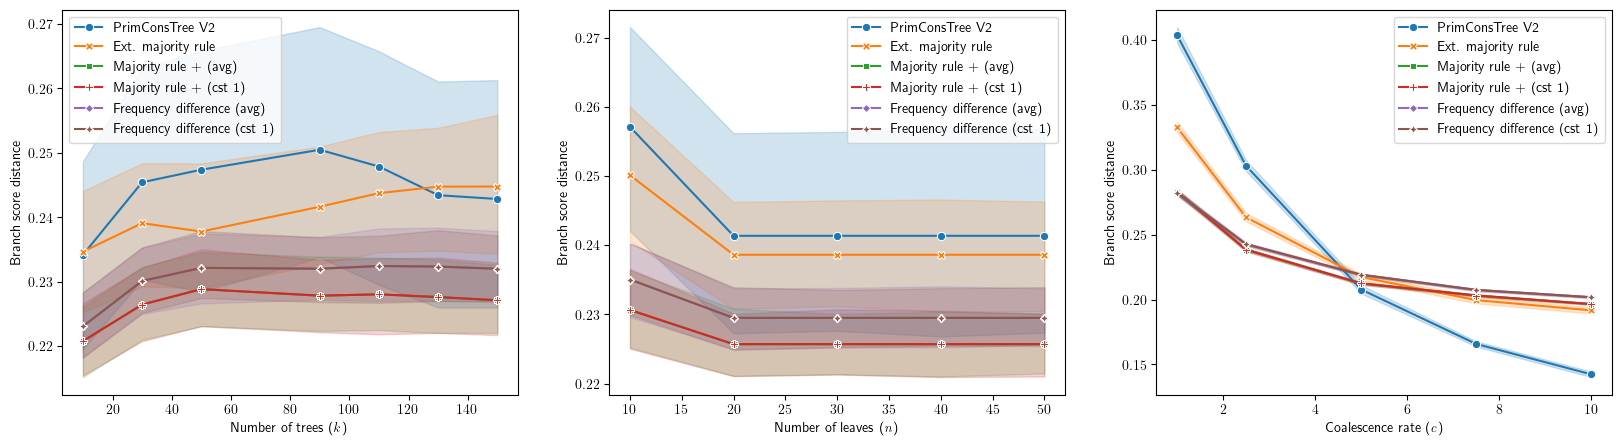

In [8]:
if "bsd_" in run_dists:
    plot_metric(df, "bsd_", ["k", "n", "c"], DEFAULT_ALGS)
    plt.show()
    #plt.savefig('../img/bsd.eps', dpi=300)

## 5. Kendall-Colijn for several lambda

Lambda value control the weight of the branch length in the metric : from 0 (do not account for branch lenght) to 1 (completly account for branch length)

### 5.1. KC with lambda 0.0

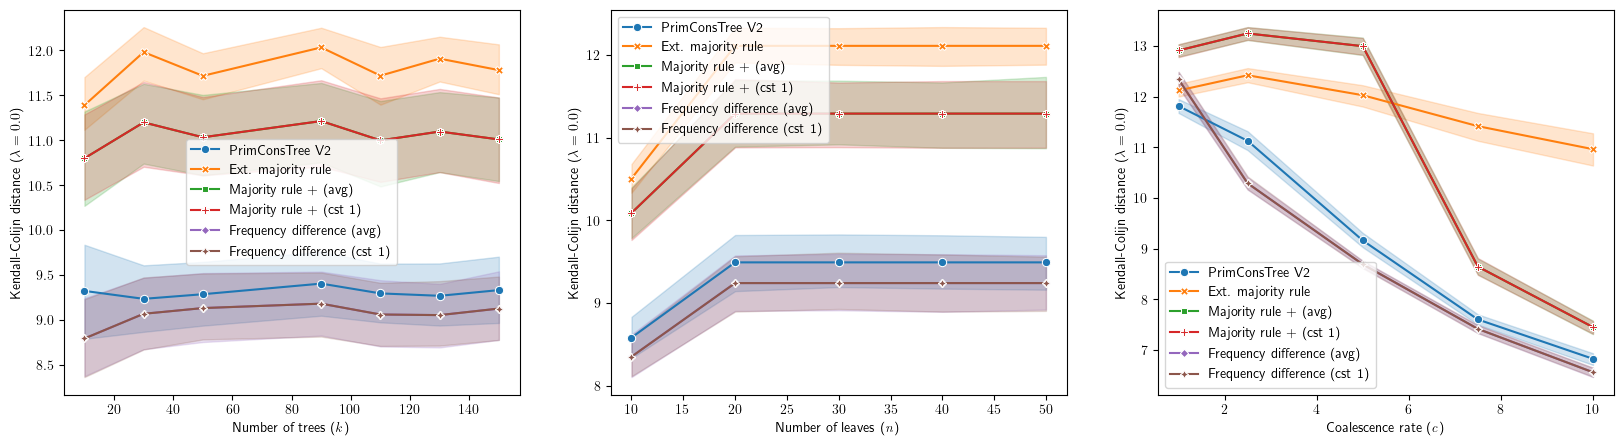

In [9]:
if "kcdist_lamb0.0" in run_dists:
    _, axes = plot_metric(df, "kcdist_lamb0.0", ["k", "n", "c"], DEFAULT_ALGS)
    plt.show()
    #plt.savefig('../img/triplet.pdf', dpi=300)

### 5.2. KC with lambda 0.5

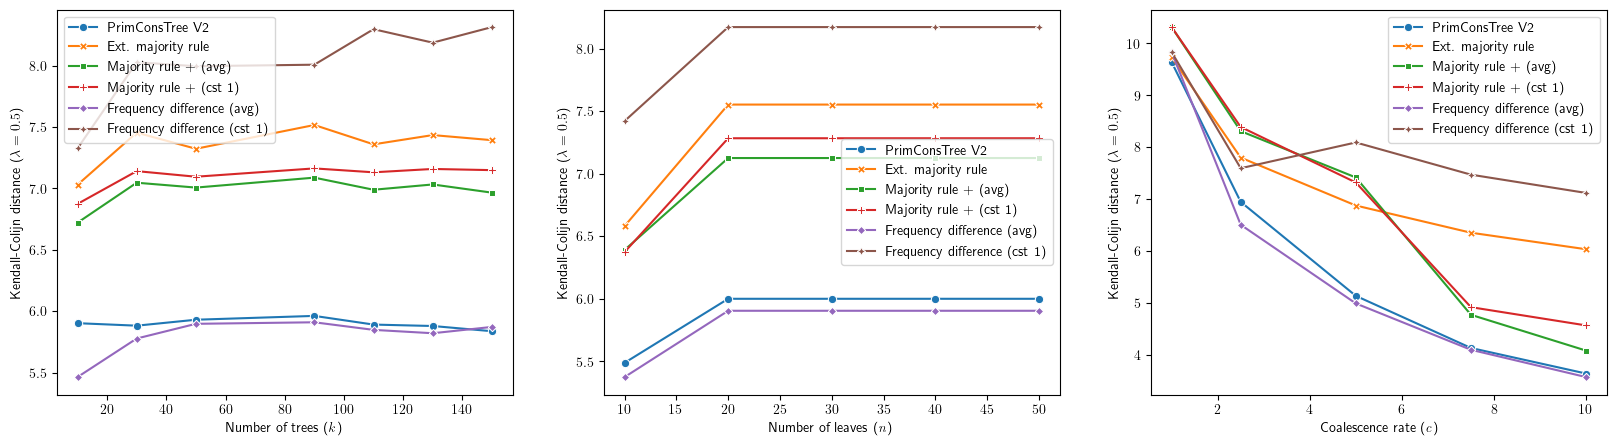

In [10]:
if "kcdist_lamb0.5" in run_dists:
    _, axes = plot_metric(df, "kcdist_lamb0.5", ["k", "n", "c"], DEFAULT_ALGS, errorbar=None)
    plt.show()
    #plt.savefig('../img/triplet.pdf', dpi=300)

### 5.3. KC with lambda 1.0

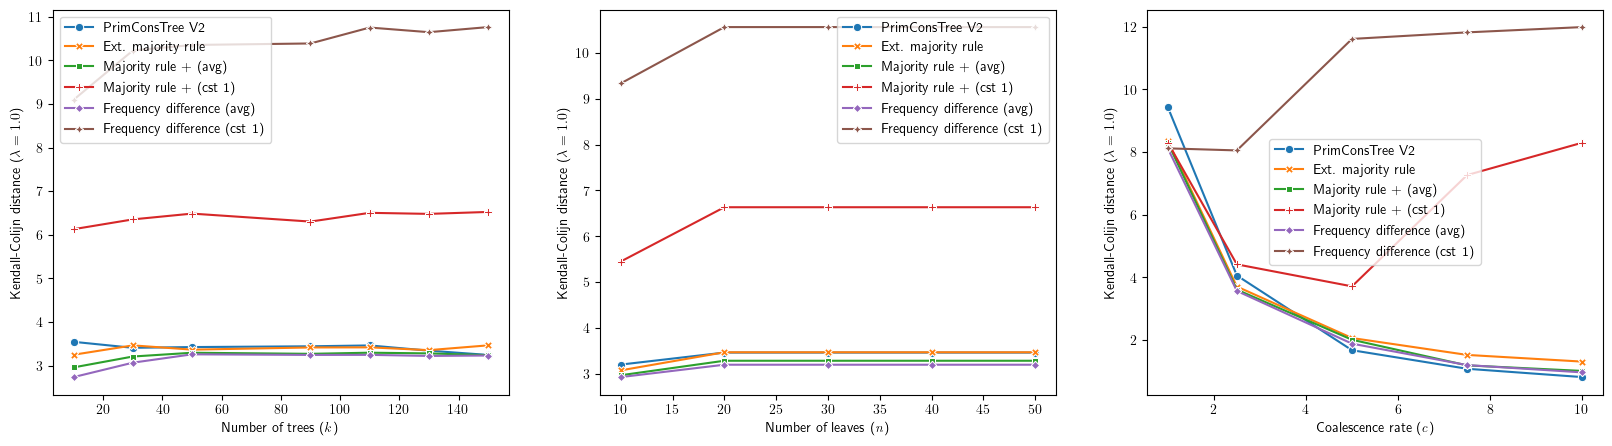

In [11]:
if "kcdist_lamb1.0" in run_dists:
    _, axes = plot_metric(df, "kcdist_lamb1.0", ["k", "n", "c"], DEFAULT_ALGS, errorbar=None)
    plt.show()
    #plt.savefig('../img/triplet.pdf', dpi=300)

### 5.4. KC distance with respect to the lambda value

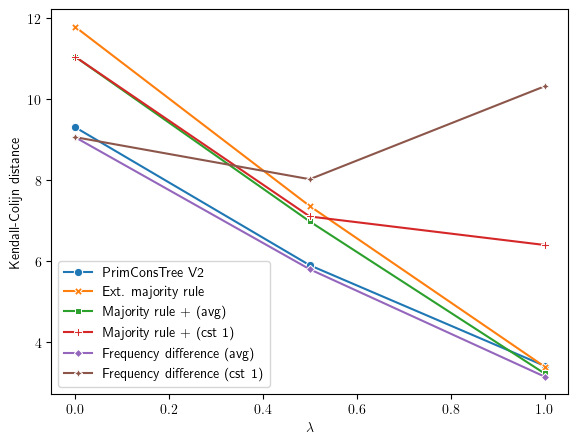

In [12]:
kc_cols = [c for c in df.columns if c.startswith("kcdist")]
other_cols = [c for c in df.columns if not c in kc_cols]

if len(kc_cols) > 0:
    kc_df = df.melt(
        id_vars=other_cols,
        value_vars=kc_cols,
        value_name="kcdist",
        var_name="kcdistname",
    )
    kc_df["lambda"] = kc_df.apply(lambda x: get_lambda(x["kcdistname"]), axis=1)

    _, axes = plot_metric(kc_df, "kcdist", ["lambda"], DEFAULT_ALGS, errorbar=None)
    
    #fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    #sns.lineplot(data=df[~df["lambda"].isna()], x="lambda", y="kcdist", hue="algorithm", , ax=ax, markers=True, style="algorithm", dashes=False, errorbar=None)
    #set_y_label("kcdist", ax)
    #set_x_label("lambda", ax)
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles=handles, labels=labels)  
    
    plt.show()
    #plt.savefig('../img/Lamb_Figure.pdf', dpi=300)

### 5.5. Final boss of the KC figures

This summarize 4.1 to 4.3 in one big figure with each row being a parameter (k, n, c) and each column being a value of lambda (0, 0.5, 1)

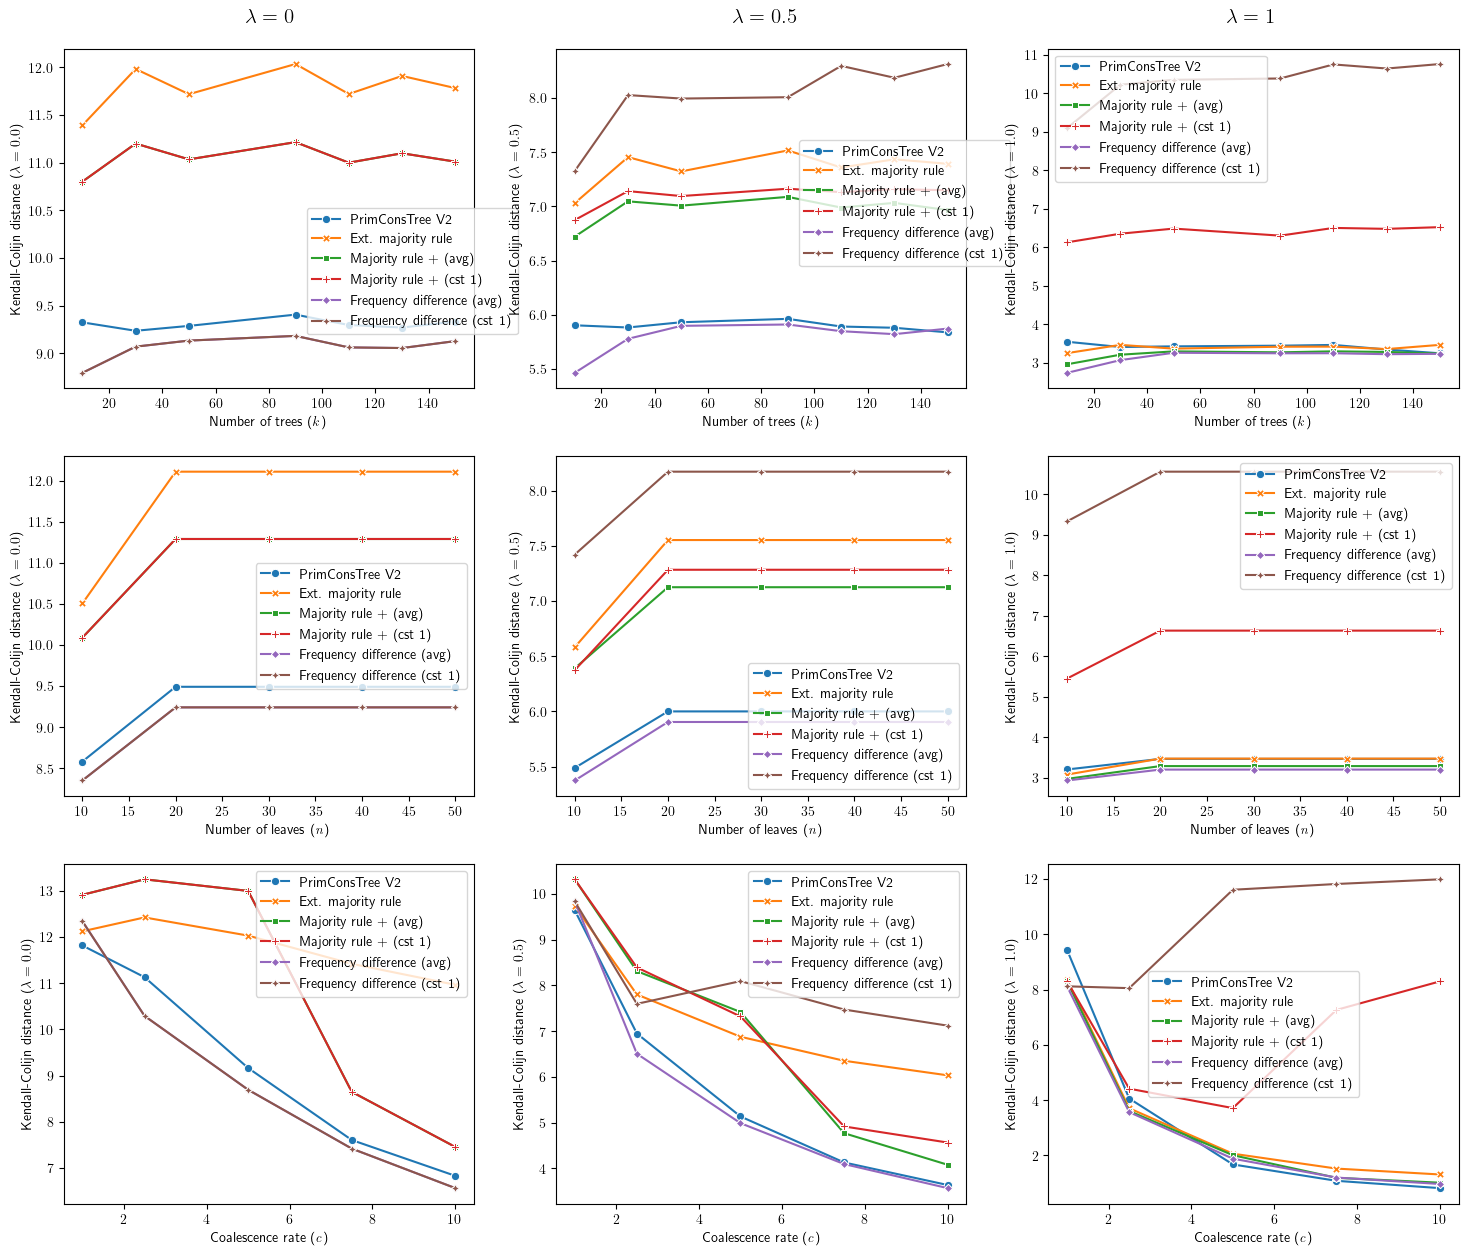

In [13]:
if "kcdist_lamb0.0" in run_dists and "kcdist_lamb0.5" in run_dists and "kcdist_lamb1.0" in run_dists:
    fig, axes = figure(df, ["kcdist_lamb0.0", "kcdist_lamb0.5", "kcdist_lamb1.0"], ["k", "n", "c"], DEFAULT_ALGS)           
    axes[0][0].legend(loc='upper left', bbox_to_anchor=(0.575, 0.55))
    axes[0][1].legend(loc='upper left', bbox_to_anchor=(0.575, 0.75))
    fig.text(0.24, 0.9, r'$\lambda = 0$', ha='center', va='center', fontsize=15)
    fig.text(0.515, 0.9, r'$\lambda = 0.5$', ha='center', va='center', fontsize=15)
    fig.text(0.785, 0.9, r'$\lambda = 1$', ha='center', va='center', fontsize=15)
    plt.show()
    #plt.savefig('../img/KC_Figure.pdf', dpi=300)

## 3. Execution time for varying k, n, c

For each batch of input trees, the consensus methods are executed 10 times, and the minimum value is retained.

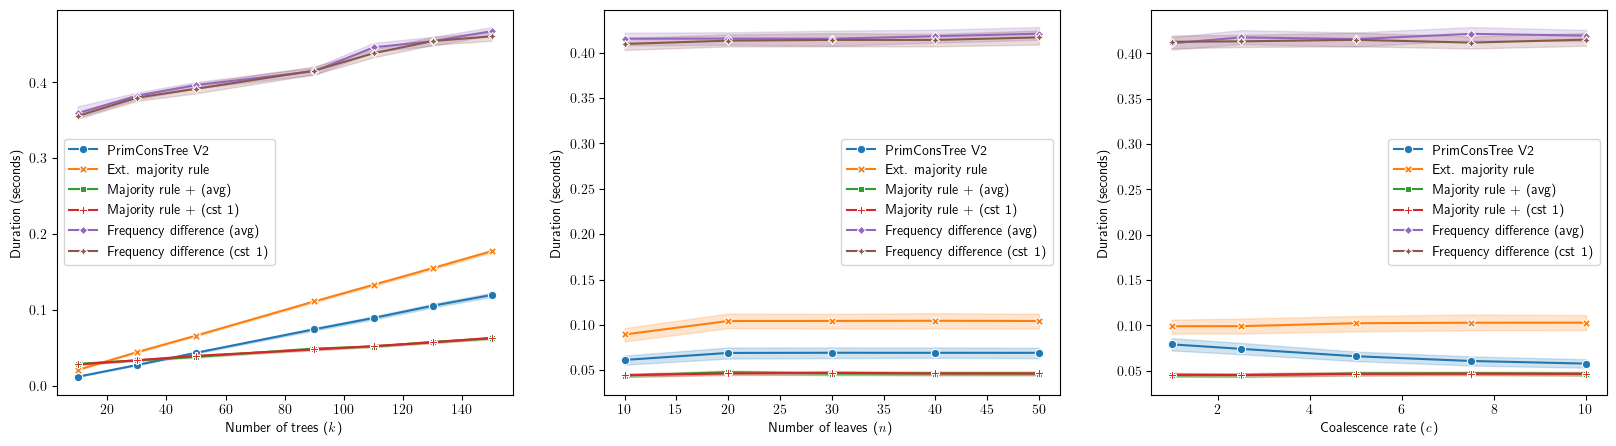

In [14]:
if "duration" in run_dists:
    plot_metric(df, "duration", ["k", "n", "c"], DEFAULT_ALGS)
    plt.show()
    #plt.savefig('../img/duration.pdf', dpi=300)